## **STAT 301 Group Project Final Report**


**(1) Introduction**
Start with relevant background information on the topic to prepare those unfamiliar for the rest of your proposal.
Formulate one or two questions for investigation and detail the dataset that will be utilized to address these questions.
Additionally, align your question/objectives with the existing literature. To contextualize your study, include a minimum of two scientific publications (these should be listed in the References section).


**(2) Methods and Results**

**a) “Exploratory Data Analysis (EDA)”**
Demonstrate that the dataset can be read into R.
Clean and wrangle your data into a tidy format.
Plot the relevant raw data, tailoring your plot to address your question.
Make sure to explore the association of the explanatory variables with the response.
Any summary tables that are relevant to your analysis.
Be sure not to print output that takes up a lot of screen space.
Your EDA must be comprehensive with high quality plots.


**b) “Methods: Plan”**
Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant? How does the model fit the data)?
A careful model assessment must be conducted.
If prediction is the project's aim, describe the test data used or how it was created.
Ensure your tables and/or figures are labelled with a figure/table number.


## (1) Methods and plan (Ellie)

**1.1 Note: changes from proposal**
<br> Note that I made the following changes to initial data cleaning and visualisation since the initial proposal:
1. Removed columns 'Is Fork', 'Is Template', 'Has Issues', 'Has Downloads' and 'Is Archived' for the reason that these columns were either entirely or nearly (>90%) constant, i.e. almost all values same, meaning they would not be helpful to include as possible predictors in future analysis and model selection.
2. Log-transformed 'Forks' variable.
3. Added scatterplot comparing 'Stars' and 'Forks'.
4. Took a stratified random sample to use for future analysis, rather than simple random sample, where half of the observations have a "high" number of stars (>= median) and half have a "low" number. This ensures a more even distribution of Stars in our sample.
5. Made slight changes to the wording of my research question.

**1.2 Addressing key assumptions:**

*(a) No severe multicollinearity*
<br> To check for multicollinearity, I will create a correlation matrix to identify significant linear associations or dependencies between covariates.

*(b) Approximately linear relationship*
<br> We assume a roughly linear relationship between response and covariates. Preliminary analysis suggests a fairly linear relationship between `Stars` and `Forks`, supporting this assumption.

*(c) No ommitted key covariates*
<br> All variables excluded from the original dataset were intentionally removed in confidence that they are not relevant predictors for `Stars`.

*(d) Independence of observations*
<br> We assume each repository is distinct and independent from one another.

**1.3 Overview of model selection method**
<br> I chose forward selection as my method of selecting a reduced model. This approach begins with the intercept-only model and adds covariates one at a time, selecting the best model of each size (i.e. number of covariates) based on the lowest residual sum of squares (RSS). Based on these results I will select the model with the lowest $C_p$ value, which identifies the best predictive model regarding goodness of fit. To evaluate its performance, I will compare this reduced model against a full model (regressing `Stars` on all 7 covariates) using Root Mean Squared Error (RMSE) to analyze the predictive power of the selected covariates and address our research question.

Forward selection is appropriate for this analysis because it is computationally efficient, simple to implement, and adheres to the principle of parsimony, balancing predictive power and interpretability. This aligns with my goal of identifying the subset of covariates that will be most helpful in predicting `Stars` while maintaining interpretability.

However, forward selection has some limitations. It may not find the globally optimal model, especially if certain variables improve predictive power only when included together. Additionally, it focuses on minimizing in-sample error, which may not ensure the model generalizes well to new data. Comparing the RMSE of the reduced and full models will help address this concern.

By applying forward selection and evaluating the resulting model, I aim to identify a reduced model with strong predictive power and interpretability, effectively addressing my research question.

In [1]:
library(broom)
library(repr)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(modelr)
library(tidyverse)
library(dplyr)

install.packages("gridExtra")

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘modelr’


The following objects are masked from ‘package:mltools’:

    mse, rmse


The following object is masked from ‘package:broom’:

    bootstrap


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::combine()    masks gridExtra::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ modelr::mse()       masks mltools::mse()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::replace_na() masks mltools::replace_na()
✖ modelr::rmse()      masks mltools::rmse()
✖ lubridate::stamp(

In [2]:
set.seed(8035)
library(readr)
# Read in the dataset
repo <- read_csv("./repositories.csv")
# Remove unused columns, take stratified random sample grouped by Stars >= median and Stars < median
stars_med = median(repo$Stars)
repo_strat_sample <- repo %>%
    select(-Name, -Homepage, -Description, -Watchers, -URL, -'Created At', -'Updated At', -Language, -License, -Topics, -'Default Branch', -'Is Archived', -'Is Fork', 'Is Template', -'Has Issues', -'Has Downloads') %>%
    mutate(no_stars = ifelse(Stars >= stars_med, "high", "low")) %>%
    group_by(no_stars) %>%
    sample_n(size = 500, replace = FALSE) %>%
    ungroup() %>%
    select(-no_stars)
head(repo_strat_sample)

Rows: 215029 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): Name, Description, URL, Homepage, Language, License, Topics, Defau...
dbl  (5): Size, Stars, Forks, Issues, Watchers
lgl  (9): Has Issues, Has Projects, Has Downloads, Has Wiki, Has Pages, Has ...
dttm (2): Created At, Updated At

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Size,Stars,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
28512,413,119,3,TRUE,TRUE,FALSE,FALSE,FALSE
3627,952,145,132,TRUE,TRUE,FALSE,FALSE,FALSE
9586,1175,167,29,TRUE,TRUE,FALSE,FALSE,FALSE
1248,848,122,40,TRUE,TRUE,FALSE,FALSE,FALSE
6480,1283,409,34,TRUE,TRUE,TRUE,FALSE,FALSE
3556,578,104,2,FALSE,FALSE,FALSE,FALSE,FALSE


In [3]:
# Log-transform Stars, Size, Forks, Issues columns, and set 'Has Discussions' as factor
repo_sample_log <- repo_strat_sample %>%
    mutate(Size = log(Size + 1),
          Stars = log(Stars + 1),
           Forks = log(Forks + 1),
           Issues = log(Issues + 1),
          `Has Discussions` = as.factor(`Has Discussions`))
head(repo_sample_log)

Size,Stars,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>
10.258115,6.025866,4.787492,1.386294,TRUE,TRUE,FALSE,FALSE,FALSE
8.196437,6.859615,4.983607,4.890349,TRUE,TRUE,FALSE,FALSE,FALSE
9.168163,7.069874,5.123964,3.401197,TRUE,TRUE,FALSE,FALSE,FALSE
7.130099,6.744059,4.812184,3.713572,TRUE,TRUE,FALSE,FALSE,FALSE
8.776630,7.157735,6.016157,3.555348,TRUE,TRUE,TRUE,FALSE,FALSE
8.176673,6.361302,4.653960,1.098612,FALSE,FALSE,FALSE,FALSE,FALSE


## (2) Computational code and output (Ellie)
**2.1 Implementation of proposed model**

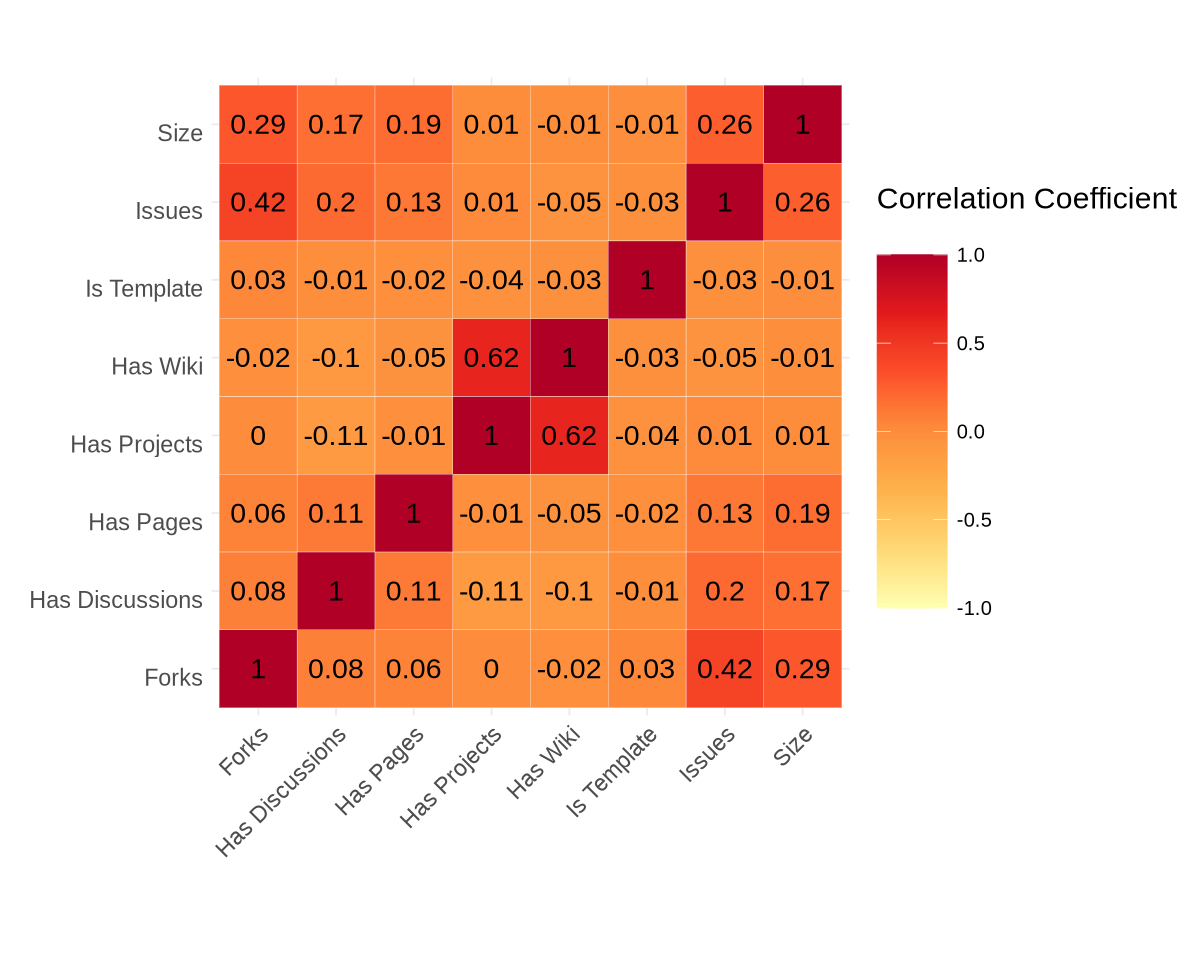

In [4]:
# Main developer: Ellie
# Check for multicollinearity among covariates using correlation matrix on heatmap
options(repr.plot.width = 10, repr.plot.height = 8) 
repo_sample_log_bin <- 
    repo_sample_log %>%
    mutate(across(where(is.logical), as.numeric)) %>%
    mutate(`Has Discussions` = as.numeric(`Has Discussions`))
corr_matrix_repo <-
    repo_sample_log_bin %>%
    select(-Stars) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
plot_corr_matrix_repo <-
    corr_matrix_repo %>%
    ggplot(mapping = aes(var1, var2)) +
    geom_tile(mapping = aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_repo

Note that the largest (in absolute value) correlation coefficient is between 'Has Wiki' and 'Has Projects', with a value of 0.62. This is noticeable but not large enough to be cause for concern or to consider dropping either variable.

In [5]:
# Main developer: Ellie
# Split into training and testing set, reorder so that Stars is first column
repo_sample_log <- 
    repo_sample_log %>%
    mutate(id = row_number()) %>%
    select(Stars, everything())

training_repo <-
    repo_sample_log %>%
    slice_sample(prop = 0.7, replace = FALSE)

testing_repo <-
    repo_sample_log %>%
    anti_join(training_repo, by = "id") %>%
    select(-id)

training_repo <- 
    training_repo %>%
    select(-id)
head(training_repo)

Stars,Size,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>
5.690359,9.509407,4.418841,1.386294,TRUE,TRUE,TRUE,TRUE,FALSE
5.950643,9.899580,3.784190,0.000000,TRUE,TRUE,FALSE,FALSE,FALSE
6.942157,9.435322,5.370638,1.386294,TRUE,TRUE,FALSE,FALSE,FALSE
5.262690,2.833213,1.945910,1.791759,TRUE,TRUE,FALSE,FALSE,FALSE
6.606650,6.220590,3.713572,1.945910,FALSE,FALSE,FALSE,TRUE,FALSE
6.192362,6.736967,3.761200,0.000000,FALSE,FALSE,FALSE,FALSE,FALSE


In [6]:
# Main developer: Ellie
# Full model (use as baseline for comparison)
repo_full <- lm(Stars ~., training_repo)
summary(repo_full)


Call:
lm(formula = Stars ~ ., data = training_repo)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7279 -0.4369 -0.0489  0.3842  3.2698 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.024191   0.089451  44.988  < 2e-16 ***
Size                  -0.019413   0.007737  -2.509 0.012216 *  
Forks                  0.532306   0.016256  32.745  < 2e-16 ***
Issues                 0.071170   0.013518   5.265 1.62e-07 ***
`Has Projects`TRUE    -0.246463   0.067021  -3.677 0.000245 ***
`Has Wiki`TRUE        -0.020357   0.056788  -0.358 0.720041    
`Has Pages`TRUE       -0.021039   0.047581  -0.442 0.658433    
`Has Discussions`TRUE  0.192902   0.056536   3.412 0.000663 ***
`Is Template`TRUE     -0.308181   0.169189  -1.822 0.068742 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6711 on 1391 degrees of freedom
Multiple R-squared:  0.5412,	Adjusted R-squared:  0.5385 
F-statistic: 

In [7]:
# Main developer: Ellie
# Obtain out-of-sample predictions for repos in testing set, using full model
repo_test_pred_full <- predict(repo_full, newdata = testing_repo)
head(repo_test_pred_full)

1        2        3        4        5        6 
6.420976 6.057504 6.368967 6.371196 6.521831 6.716102

In [8]:
# Main developer: Ellie
# Compute Root Mean Squared Error to evaluate full predictive model
repo_RMSE_models <- tibble(
    Model = "Full Regression",
    RMSE = rmse(model = repo_full,
                data = testing_repo)
    )
repo_RMSE_models

Model,RMSE
<chr>,<dbl>
Full Regression,0.6734007


In [9]:
# Main developer: Ellie
# Use forward-selection to select a reduced linear regression model
repo_forward_selection <- leaps::regsubsets(
    x = Stars ~., nvmax = 7,
    data = training_repo,
    method = "forward")

repo_forward_summary <- summary(repo_forward_selection)
repo_forward_summary <- tibble(
    n_input_variables = 1:7,
    RSS = repo_forward_summary$rss,
    BIC = repo_forward_summary$bic,
    Cp = repo_forward_summary$cp)
summary(repo_forward_selection)
repo_forward_summary

Subset selection object
Call: regsubsets.formula(x = Stars ~ ., nvmax = 7, data = training_repo, 
    method = "forward")
8 Variables  (and intercept)
                      Forced in Forced out
Size                      FALSE      FALSE
Forks                     FALSE      FALSE
Issues                    FALSE      FALSE
`Has Projects`TRUE        FALSE      FALSE
`Has Wiki`TRUE            FALSE      FALSE
`Has Pages`TRUE           FALSE      FALSE
`Has Discussions`TRUE     FALSE      FALSE
`Is Template`TRUE         FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         Size Forks Issues `Has Projects`TRUE `Has Wiki`TRUE `Has Pages`TRUE
1  ( 1 ) " "  "*"   " "    " "                " "            " "            
2  ( 1 ) " "  "*"   "*"    " "                " "            " "            
3  ( 1 ) " "  "*"   "*"    "*"                " "            " "            
4  ( 1 ) " "  "*"   "*"    "*"                " "            " "            
5  ( 1 ) "*"  "*"

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,662.8148,-997.1795,75.843373
2,648.1481,-1021.2623,45.274512
3,635.3031,-1042.0419,18.750963
4,631.0074,-1044.2962,11.211926
5,628.0452,-1043.6396,6.634049
6,626.5510,-1039.7300,5.316114
7,626.4665,-1032.6746,7.128506


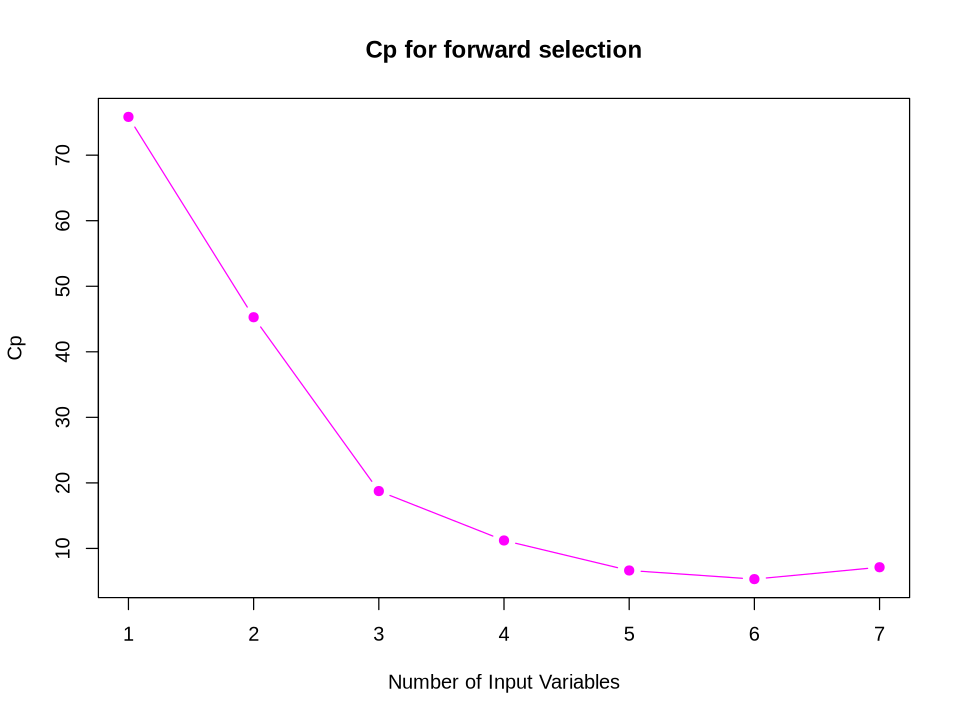

In [10]:
# Main developer: Ellie
# Visualize Cp values of models
options(repr.plot.width = 8, repr.plot.height = 6) 
plot(summary(repo_forward_selection)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", 
     ylab = "Cp",
     type = "b",
     pch = 19,
     col = "magenta"
)

In [11]:
# Main developer: Ellie
# We select the model with the lowest Cp value
repo_selection_summary <- summary(repo_forward_selection)
cp_min = which.min(repo_selection_summary$cp)
variables = repo_selection_summary$which[cp_min, ]
repo_reduced = lm(Stars ~ ., data = training_repo[variables])
summary(repo_reduced)


Call:
lm(formula = Stars ~ ., data = training_repo[variables])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7253 -0.4365 -0.0478  0.3818  3.2752 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.021001   0.088882  45.240  < 2e-16 ***
Size                  -0.019935   0.007645  -2.607 0.009220 ** 
Forks                  0.532432   0.016241  32.783  < 2e-16 ***
Issues                 0.071058   0.013449   5.284 1.47e-07 ***
`Has Projects`TRUE    -0.261218   0.051853  -5.038 5.33e-07 ***
`Has Discussions`TRUE  0.191577   0.056292   3.403 0.000685 ***
`Is Template`TRUE     -0.308132   0.169060  -1.823 0.068575 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6707 on 1393 degrees of freedom
Multiple R-squared:  0.5411,	Adjusted R-squared:  0.5391 
F-statistic: 273.7 on 6 and 1393 DF,  p-value: < 2.2e-16


**2.2 Table to report results**

In [12]:
# Main developer: Ellie
# Compare RMSE of reduced model with that of full (baseline) model
repo_RMSE_models_compare <-
    rbind(
        model = repo_RMSE_models,
        data = tibble(Model = "Reduced Regression",
                      RMSE = rmse(model = repo_reduced,
                                  data = testing_repo))
        )
repo_RMSE_models_compare
# Print names of selected covariates
selected_var <- names(coef(repo_forward_selection, cp_min))[-1]
selected_var

,Model,RMSE
,<chr>,<dbl>
1,Full Regression,0.6734007
2,Reduced Regression,0.6725432


[1] "Size"                  "Forks"                 "Issues"               
[4] "`Has Projects`TRUE"    "`Has Discussions`TRUE" "`Is Template`TRUE"

**2.3 Interpretation of results**
<br> The table above shows that the Root Mean Squared Error of our reduced model, selected using forward selection and containing 4 covariates, is slightly lower than that of the full model containing all 7 covariates. This suggests that our reduced model has slightly higher prediction performance compared with the full model. To address our research question: the results suggest that we can use two continuous variables (Forks and Issues) and two categorical variables (Has Pages and Has Discusssions) to predict the number of Stars that a repository has.

**(3) Discussion**
In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.
Summarize what you found and the implications/impact of your findings.
If relevant, discuss whether your results were what you expected to find.
Discuss how your model could be improved;
Discuss future questions/research this study could lead to.


**(4) References**
At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.
